
# Transformada de Fourier — Guía Visual y Didáctica

Este cuaderno te guía paso a paso para **entender y visualizar** la Transformada de Fourier (TF) y su versión discreta (DFT/FFT).  
Trabajaremos con señales sintéticas, exploraremos espectros de **amplitud y fase**, miraremos **aliasing**, **fuga espectral (leakage)**, **ventaneo**, y terminaremos con un **espectrograma (STFT)**.

> Requisitos: `numpy`, `matplotlib` (ya vienen en la mayoría de entornos Python/Colab/Jupyter).


In [14]:

import numpy as np
import matplotlib.pyplot as plt

# Asegurar reproducibilidad
rng = np.random.default_rng(42)

def make_signal(t, components, noise_std=0.0):
    """
    Genera una señal como suma de senoidales + ruido gaussiano opcional.
    components: lista de tuplas (amplitud, frecuencia, fase_en_rad)
    """
    x = np.zeros_like(t)
    for A, f, ph in components:
        x += A * np.sin(2*np.pi*f*t + ph)
    if noise_std > 0:
        x += rng.normal(0, noise_std, size=t.shape)
    return x

def amplitude_phase_from_fft(X, N, fs):
    """
    Calcula los ejes de frecuencia, amplitud (espectro a 1 cara) y fase.
    Asume señal real para construir el espectro de 1 cara.
    """
    # Frecuencias (bins)
    freqs = np.fft.rfftfreq(N, d=1/fs)
    # FFT (1 lado)
    X_r = np.fft.rfft(X)
    # Escala amplitud: tomar magnitud y normalizar por N, multiplicar por 2 (excepto DC y Nyquist si N par)
    mag = np.abs(X_r) / N
    if N % 2 == 0:
        mag[1:-1] *= 2.0
    else:
        mag[1:] *= 2.0
    phase = np.angle(X_r)
    return freqs, mag, phase

def plot_time(t, x, title="Señal en el tiempo", xlabel="Tiempo [s]", ylabel="Amplitud"):
    plt.figure(figsize=(10, 3.5))
    plt.plot(t, x)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

def plot_spectrum(freqs, mag, title_mag="Espectro de amplitud"):
    plt.figure(figsize=(10, 3.5))
    plt.stem(freqs, mag)
    plt.title(title_mag)
    plt.xlabel("Frecuencia [Hz]")
    plt.ylabel("Amplitud")
    plt.grid(True)
    plt.show()



## 1) De una señal senoidal a su espectro

Partamos de una sola senoide. Verás cómo su **frecuencia** aparece como un **pico** en el dominio de la frecuencia.


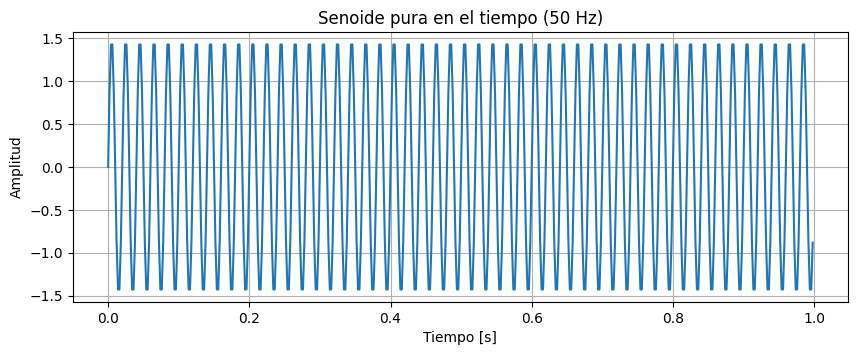

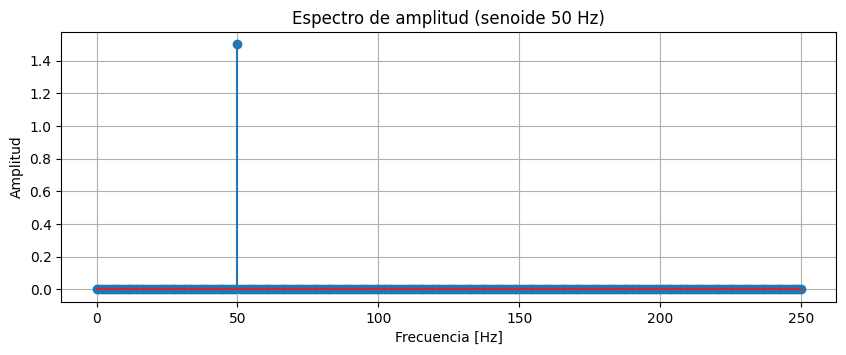

In [15]:

fs = 500.0          # Hz (frecuencia de muestreo)
T = 1.0             # s  (duración)
N = int(fs*T)       # muestras
t = np.arange(N) / fs

f0 = 50.0           # Hz (frecuencia de la senoide)
A0 = 1.5            # amplitud
phi0 = 0      # fase inicial

x = make_signal(t, [(A0, f0, phi0)], noise_std=0.0)

plot_time(t, x, title="Senoide pura en el tiempo (50 Hz)")

freqs, mag, phase = amplitude_phase_from_fft(x, N, fs)
plot_spectrum(freqs, mag, 
              title_mag="Espectro de amplitud (senoide 50 Hz)",)


## 2) Suma de senoides

La Transformada de Fourier es **lineal**: la TF de una suma es la suma de las TF.  
Agreguemos otra componente para ver múltiples picos.


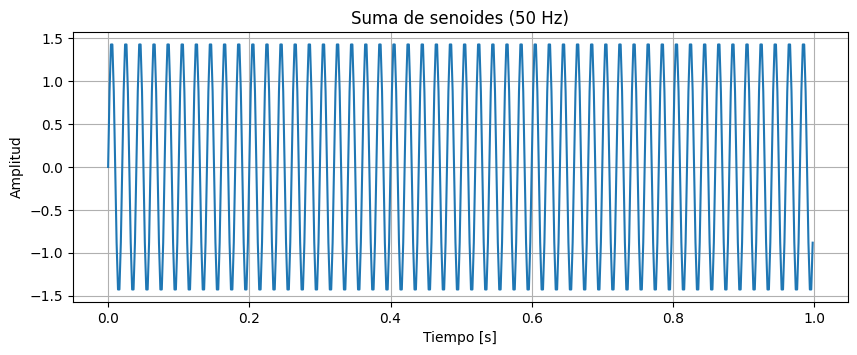

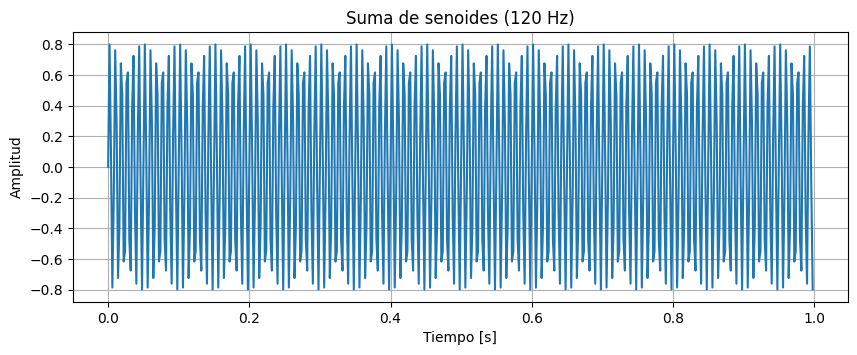

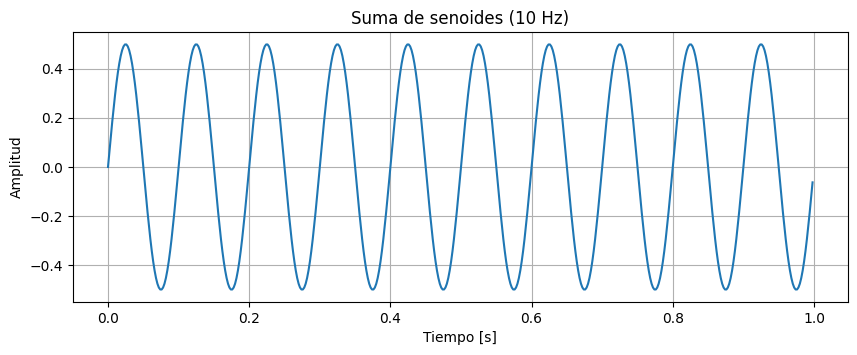

In [20]:
signal_50 = make_signal(t, [(1.5, 50.0, 0)])
signal_120 = make_signal(t, [(0.8, 120.0, 0)])
signal_200 = make_signal(t, [(0.5, 10.0, 0)])

plot_time(t, signal_50, title="Suma de senoides (50 Hz)")
plot_time(t, signal_120, title="Suma de senoides (120 Hz)")
plot_time(t, signal_200, title="Suma de senoides (10 Hz)")

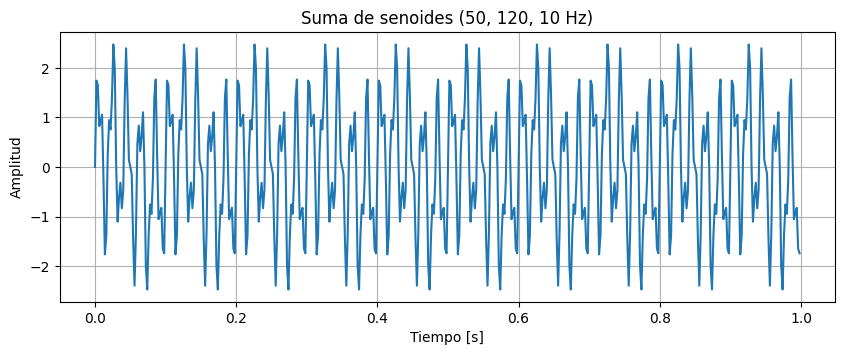

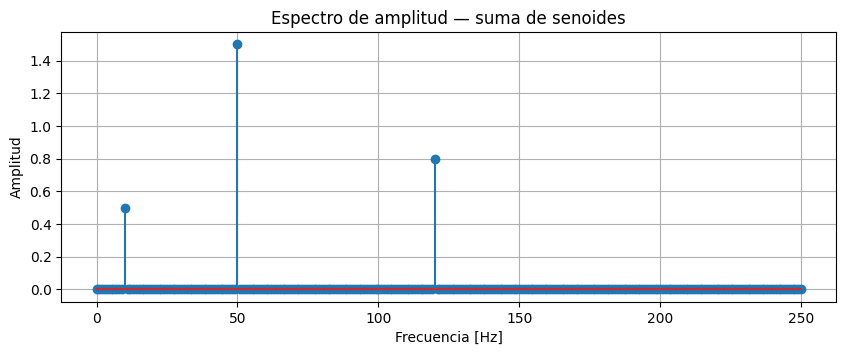

In [ ]:
signal_sum = signal_50 + signal_120 + signal_200

plot_time(t, signal_sum, title="Suma de senoides (50, 120, 10 Hz)")

freqs2, mag2, phase2 = amplitude_phase_from_fft(signal_sum, N, fs)
plot_spectrum(freqs2, mag2,
              title_mag="Espectro de amplitud — suma de senoides")


## 3) Ruido y SNR

Agreguemos ruido blanco gaussiano para observar cómo **se eleva el piso de ruido** en el espectro.


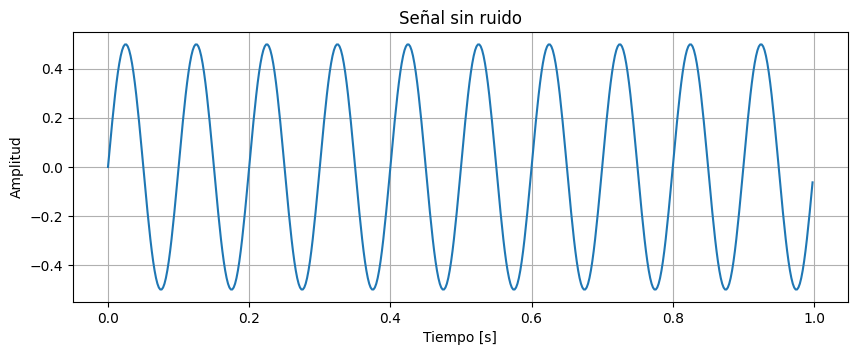

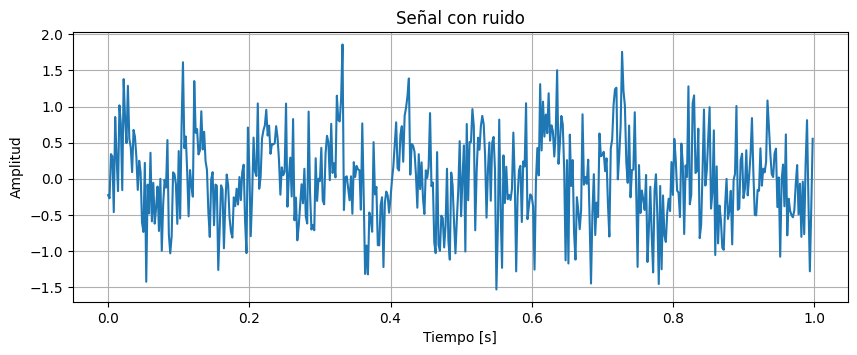

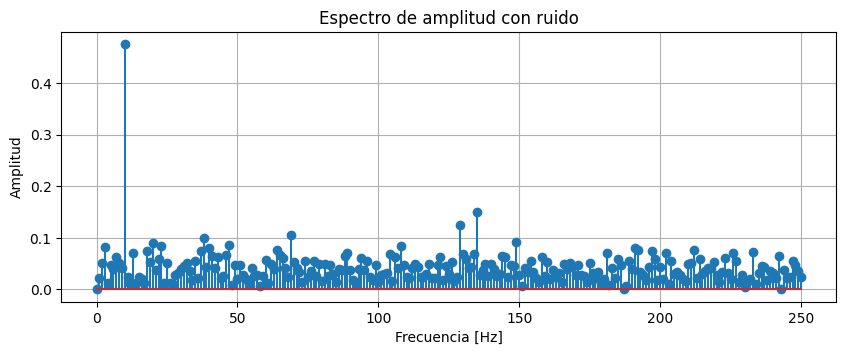

In [28]:
signal_10 = make_signal(t, [(0.5, 10.0, 0)])
signal_10_noisy = make_signal(t, [(0.5, 10.0, 0)], noise_std=0.5)

plot_time(t, signal_10, title="Señal sin ruido" )
plot_time(t, signal_10_noisy, title="Señal con ruido" )

freqs_n, mag_n, _ = amplitude_phase_from_fft(signal_10_noisy, N, fs)
plot_spectrum(freqs_n, mag_n, title_mag="Espectro de amplitud con ruido")


## 4) Resolución en frecuencia y zero-padding



### Resolución en frecuencia
Cuando aplicamos la **Transformada de Fourier** a una señal discreta, el resultado se calcula en **bins de frecuencia**.  
El espacio entre esos bins se llama **resolución en frecuencia** y se calcula como:

$$
\Delta f = \frac{f_s}{N}
$$


- $ f_s $: frecuencia de muestreo  
- $ N $: número de muestras analizadas  

👉 Esto significa que **a mayor duración de la señal (más muestras)**, **mejor resolución** tenemos en frecuencia (los picos se ven más “afilados”).  

**Ejemplo:**
- Si $ f_s = 500 $ Hz y analizamos $ N=500 $ muestras (1 segundo):  
  $\Delta f = 500 / 500 = 1 \text{ Hz}$.  
- Si duplicamos la duración a 2 s ($N=1000$):  
  $\Delta f = 500 / 1000 = 0.5 \text{ Hz}$.  

Así podemos distinguir frecuencias más cercanas.

---

### Zero-padding
El **zero-padding** significa **agregar ceros al final de la señal antes de calcular la FFT**.  

- **No mejora la resolución real** (los bins siguen separados por $\Delta f$).  
- Lo que hace es **interpolar el espectro**, dándonos más puntos en el gráfico y haciendo que se vea más suave y continuo.  

Es como si tuvieras pocos píxeles en una foto: no obtienes más detalles reales, pero al interpolar la imagen, se ve más definida.

---

✅ **Idea clave:**  
- **Más muestras = mejor resolución real.**  
- **Zero-padding = solo visualización más suave, no más resolución física.**


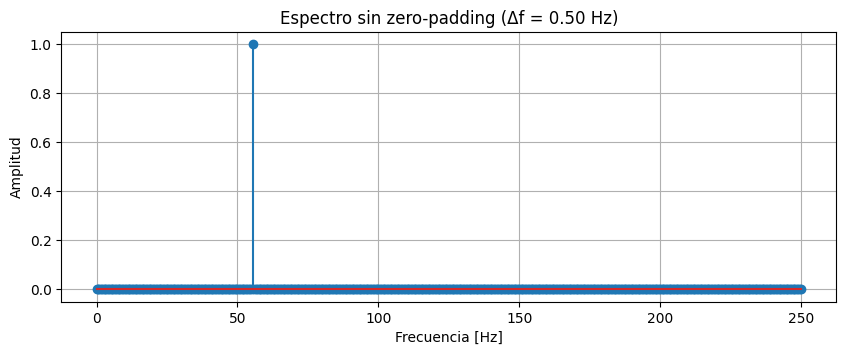

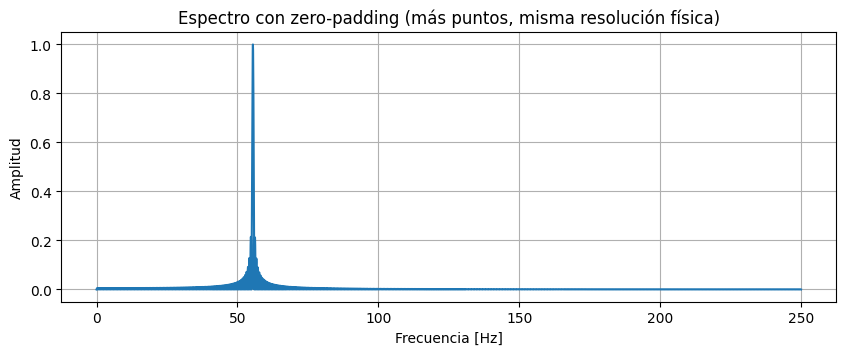

In [57]:

# Misma señal, pero probemos diferentes N y zero-padding
T_long = 2.0
N_long = int(fs*T_long)
t_long = np.arange(N_long) / fs
x_long = make_signal(t_long, [(1.0, 55.5, 0.0)])

# Sin zero-padding
freqsL, magL, _ = amplitude_phase_from_fft(x_long, N_long, fs)

# Con zero-padding (rellenar hasta 8*N_long)
pad = 8*N_long
X_pad = np.fft.rfft(x_long, n=pad)
freqs_pad = np.fft.rfftfreq(pad, d=1/fs)
mag_pad = np.abs(X_pad)/N_long
if N_long % 2 == 0:
    mag_pad[1:-1] *= 2.0
else:
    mag_pad[1:] *= 2.0

plt.figure(figsize=(10,3.5))
plt.stem(freqsL, magL)
plt.title("Espectro sin zero-padding (Δf = {:.2f} Hz)".format(fs/N_long))
plt.xlabel("Frecuencia [Hz]"); plt.ylabel("Amplitud"); plt.grid(True); plt.show()

plt.figure(figsize=(10,3.5))
plt.plot(freqs_pad, mag_pad)
plt.title("Espectro con zero-padding (más puntos, misma resolución física)")
plt.xlabel("Frecuencia [Hz]"); plt.ylabel("Amplitud"); plt.grid(True); plt.show()


# Fuga espectral y ventanas

![Fuga espectral y ventanas](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT1nuBqwsKjN9UteoYOneH2qGwv5U_BXKUaQA&s)

## Fuga espectral
Cuando la señal **no completa ciclos enteros** en la ventana de análisis, aparecen **saltos en los bordes**.  
Esto provoca que la energía de una frecuencia se **disperse en bins vecinos** del espectro.  
A esto se le llama **fuga espectral** (*spectral leakage*).

## Ventanas
Para reducir la fuga se multiplica la señal por una **ventana** (Hann, Hamming, etc.).  
La ventana suaviza los bordes → menos fuga, picos más claros.  
**Efecto secundario:** los picos se vuelven un poco más anchos (menor resolución en frecuencia).

---

✅ **En resumen:**  
- **Fuga espectral = energía se reparte en varios bins.**  
- **Ventanas = reducen la fuga pero ensanchan los picos.**



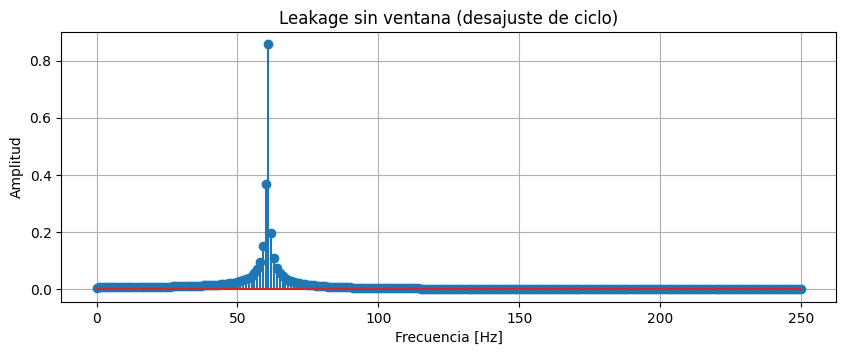

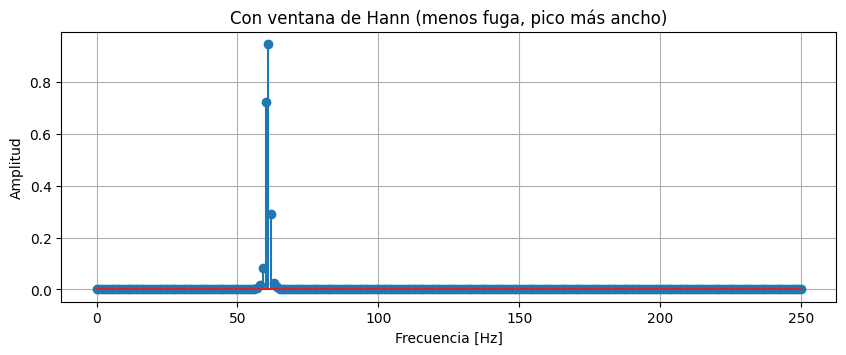

In [59]:

# Señal de 60.7 Hz para provocar desajuste de ciclo
f_leak = 60.7
x_leak = make_signal(t, [(1.0, f_leak, 0.0)])

# Sin ventana
freqs_a, mag_a, _ = amplitude_phase_from_fft(x_leak, N, fs)

# Con ventana de Hann
w = np.hanning(N)
xw = x_leak * w

# Compensación de ganancia aproximada por la ventana (normalizar energía media)
gain = np.mean(w)
freqs_b, mag_b, _ = amplitude_phase_from_fft(xw/gain, N, fs)

plt.figure(figsize=(10,3.5))
plt.stem(freqs_a, mag_a)
plt.title("Leakage sin ventana (desajuste de ciclo)")
plt.xlabel("Frecuencia [Hz]"); plt.ylabel("Amplitud"); plt.grid(True); plt.show()

plt.figure(figsize=(10,3.5))
plt.stem(freqs_b, mag_b)
plt.title("Con ventana de Hann (menos fuga, pico más ancho)")
plt.xlabel("Frecuencia [Hz]"); plt.ylabel("Amplitud"); plt.grid(True); plt.show()


## 6) Amplitud vs. potencia; módulo y fase

# Amplitud vs. Potencia

## Amplitud
- Representa la **magnitud** de cada componente sinusoidal en el espectro.  
- Indica **qué tan fuerte** aparece una frecuencia en la señal.  
- Se calcula como el **módulo de la FFT**:  

$$
A(f) = |X(f)|
$$

## Potencia
- Está relacionada con el **cuadrado de la amplitud**.  
- Indica la **energía o intensidad** que cada frecuencia aporta a la señal.  
- Se calcula como:  

$$
P(f) = |X(f)|^2
$$

---

## ¿Por qué usar uno u otro?

- **Amplitud**  
  - Útil para comparar la **fuerza relativa de frecuencias individuales**.  
  - Se usa mucho en análisis de señales periódicas (ej. tonos en audio, picos dominantes en ECG).  

- **Potencia**  
  - Se prefiere cuando interesa la **energía total** o su distribución en diferentes bandas de frecuencia.  
  - Base de la **densidad espectral de potencia (PSD)**, común en telecomunicaciones, bioseñales y análisis estadístico.  

---

✅ **En resumen:**  
- Usa **amplitud** para ver los componentes sinusoidales directamente.  
- Usa **potencia** para analizar la **energía contenida en la señal**.


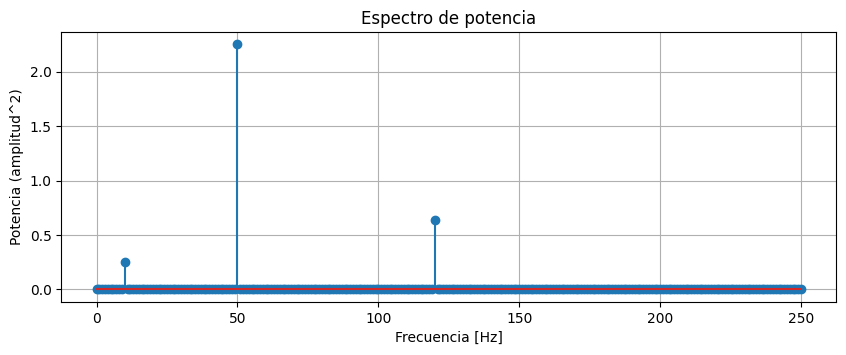

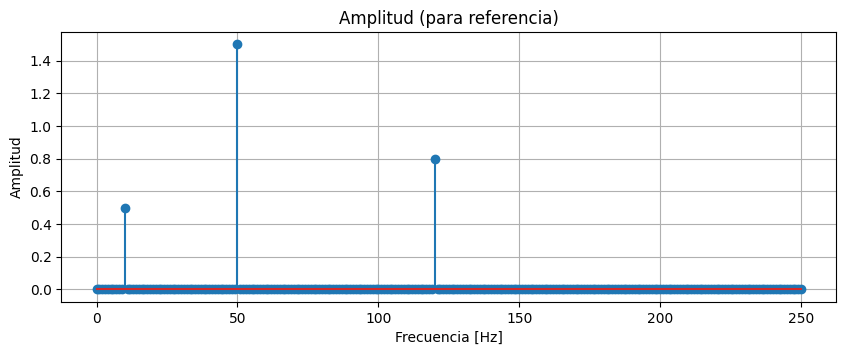

In [65]:

# Espectro de potencia (1 cara)
freqs3, mag3, phase3 = amplitude_phase_from_fft(signal_sum, N, fs)
power = mag3**2

plt.figure(figsize=(10,3.5))
plt.stem(freqs3, power)
plt.title("Espectro de potencia")
plt.xlabel("Frecuencia [Hz]"); plt.ylabel("Potencia (amplitud^2)")
plt.grid(True); plt.show()

# Mostrar fase de una de las componentes dominantes
plot_spectrum(freqs3, mag3, 
              title_mag="Amplitud (para referencia)")


## 7) Aliasing (submuestreo)

Si muestreamos por debajo del **criterio de Nyquist** (\( f_s > 2 f_{max} \)), frecuencias altas **se pliegan** y aparecen como frecuencias falsas más bajas.


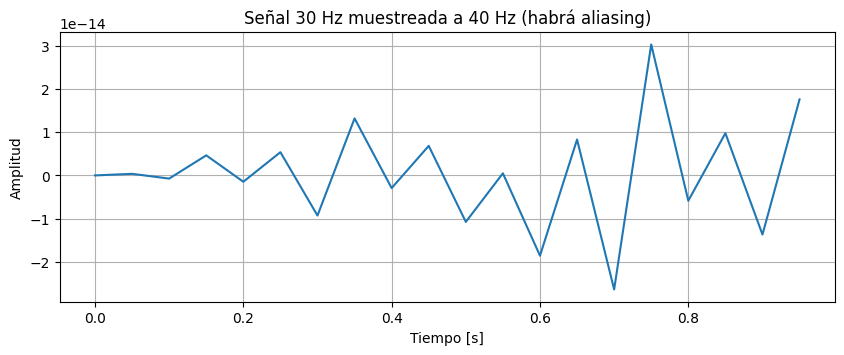

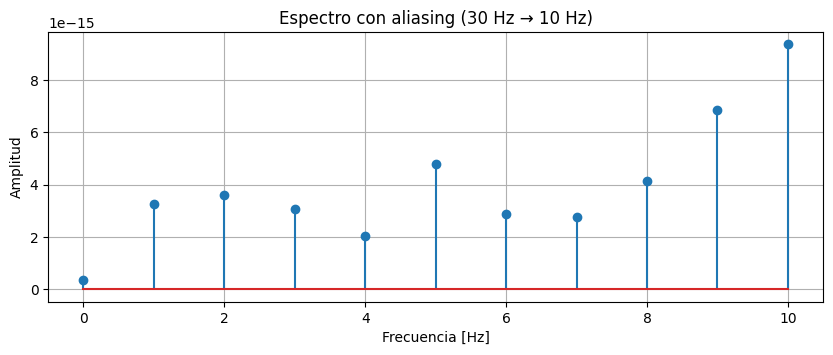

In [61]:
# Señal de 30 Hz muestreada a 40 Hz (Nyquist = 20 Hz) -> alias a 10 Hz
fs_alias = 20.0
T_a = 1.0
N_a = int(fs_alias*T_a)
t_a = np.arange(N_a)/fs_alias
x_alias = make_signal(t_a, [(1.0, 30.0, 0.0)])

plot_time(t_a, x_alias, title="Señal 30 Hz muestreada a 40 Hz (habrá aliasing)")

freqs_a, mag_a, _ = amplitude_phase_from_fft(x_alias, N_a, fs_alias)
plot_spectrum(freqs_a, mag_a, title_mag="Espectro con aliasing (30 Hz → 10 Hz)")